In [1]:
import torch 
torch.random.manual_seed(11)

import numpy as np 
np.random.seed(11)
import matplotlib.pyplot as plt 
import time

In this tutorial, we extend the two-agent example from the last tutorial to a three-agent example.

In [2]:
# We first generat the configurations of the navigation task, where do the agents start and what are their goals.

circle_radius = 3.0 
num_agents = 2
min_dist = 1.0

angle_1 = np.random.uniform(-np.pi, np.pi)
init_1 = np.array([
    np.cos(angle_1), np.sin(angle_1)
]) * circle_radius
goal_1 = -1.0 * init_1 

while True:
    angle_2 = np.random.uniform(-np.pi, np.pi)
    init_2 = np.array([
        np.cos(angle_2), np.sin(angle_2)
    ]) * circle_radius
    goal_2 = -1.0 * init_2
    
    dist = np.linalg.norm(init_2 - init_1)
    if dist > min_dist:
        break

while True:
    angle_3 = np.random.uniform(-np.pi, np.pi)
    init_3 = np.array([
        np.cos(angle_3), np.sin(angle_3)
    ]) * circle_radius
    goal_3 = -1.0 * init_3
    
    dist = np.minimum(np.linalg.norm(init_3 - init_1), np.linalg.norm(init_3 - init_2))
    if dist > min_dist:
        break

In [3]:
# Now we configure Gaussian processes as the preference for each agent

class GP:
    def __init__(self, 
                 dt: float,
                 tsteps: float,
                 kernel_a1: float,
                 kernel_a2: float) -> None:
        self.kernel_a1 = kernel_a1 
        self.kernel_a2 = kernel_a2
        self.Lcov_mat = self.get_Lcov(tsteps, dt)

        self.tsteps = tsteps 
        self.dt = dt

    def kernel(self,
               t1: torch.Tensor,
               t2: torch.Tensor):
        return torch.exp(-self.kernel_a1 * (t1-t2)**2) * self.kernel_a2
    
    def get_Lcov(self, 
                 tsteps: int, 
                 dt: float):
        time_list_1 = torch.tensor([0.0, (tsteps-1)*dt])
        time_list_2 = torch.arange(tsteps) * dt
        
        mat_11 = torch.vmap(self.kernel, in_dims=(0,None))(time_list_1, time_list_1)
        mat_12 = torch.vmap(self.kernel, in_dims=(0,None))(time_list_1, time_list_2)
        mat_22 = torch.vmap(self.kernel, in_dims=(0,None))(time_list_2, time_list_2)
        
        full_mat = mat_22 - mat_12.T @ torch.inverse(mat_11) @ mat_12
        full_mat += torch.eye(tsteps) * 1e-04
        return torch.linalg.cholesky(full_mat)

    def mvn_sampling(self,
                     num_samples: int):
        init_samples = torch.randn(size=(self.Lcov_mat.shape[0], num_samples))
        new_samples = self.Lcov_mat @ init_samples
        return new_samples.T
    
    def generate_samples(self,
                         traj: torch.Tensor,
                         num_samples: int):        
        traj_x_samples = self.mvn_sampling(num_samples) + traj[:,0]
        traj_y_samples = self.mvn_sampling(num_samples) + traj[:,1]
        traj_samples = torch.stack([traj_x_samples, traj_y_samples])
        traj_samples = torch.transpose(traj_samples, 0, 1)
        traj_samples = torch.transpose(traj_samples, 1, 2)

        return traj_samples

In [4]:
dt = 0.3 
tsteps = 20
num_samples = 200 
num_iters = 20

kernel_a1 = 0.03
kernel_a2 = 5.0

gp_pref = GP(dt=dt, tsteps=tsteps, kernel_a1=kernel_a1, kernel_a2=kernel_a2)

In [5]:
# We also need to define the risk funtion between two trajectories
# Here we first define a 2D Gaussian as the risk between two states in the 2D plan
# Then we evaluate this function over all the corresponding time steps between two trajectories, 
# ... and calculate the mean as the risk between the two trajectories.
# Again, the algorithm works with arbitrary choice of risk functions.

risk_cov = np.diag(np.random.uniform(low=0.3, high=0.8, size=2)) * 0.5
risk_cov[0,1] = np.sqrt(np.prod(np.diagonal(risk_cov))) / 2.0
risk_cov[1,0] = risk_cov[0,1]
risk_cov = torch.tensor(risk_cov, dtype=torch.float32)
risk_cov_inv = torch.linalg.inv(risk_cov)
risk_eta = 1.0 / torch.sqrt((2.0*torch.pi)**2 * torch.linalg.det(risk_cov))
def risk_traj(traj1, traj2):
    d_traj = traj1 - traj2
    vals = torch.exp(-0.5 * torch.sum(d_traj @ risk_cov_inv * d_traj, dim=1)) * 200.0
    return torch.mean(vals)

In [6]:
# We generate the initial preference for each agent and draw trajectory samples from it

traj_1 = torch.tensor(np.linspace(init_1, goal_1, tsteps), dtype=torch.float32)
weights_1 = torch.ones(num_samples)
traj_2 = torch.tensor(np.linspace(init_2, goal_2, tsteps), dtype=torch.float32)
weights_2 = torch.ones(num_samples)
traj_3 = torch.tensor(np.linspace(init_3, goal_3, tsteps), dtype=torch.float32)
weights_3 = torch.ones(num_samples)


traj_samples_1 = gp_pref.generate_samples(traj_1, num_samples)
traj_samples_2 = gp_pref.generate_samples(traj_2, num_samples)
traj_samples_3 = gp_pref.generate_samples(traj_3, num_samples)

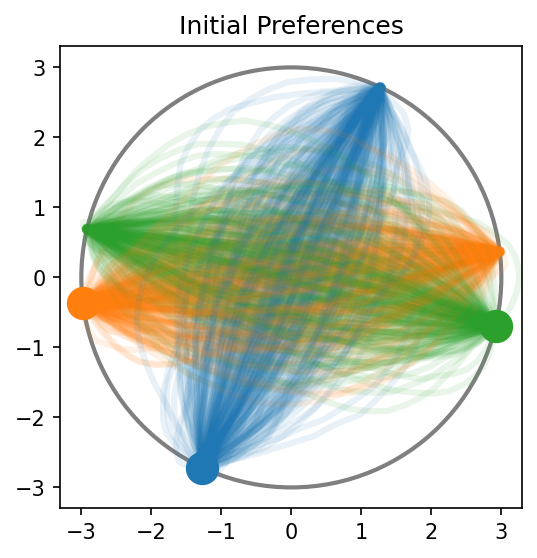

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=150)
ax.set_title('Initial Preferences')
ax.set_xlim(-1.1*circle_radius, 1.1*circle_radius)
ax.set_ylim(-1.1*circle_radius, 1.1*circle_radius)
ax.set_aspect('equal')

circle = plt.Circle((0.0, 0.0), circle_radius, fill=False, color='k', linewidth=2, alpha=0.5)
ax.add_patch(circle)

traj_1_np = traj_1.cpu().numpy()
traj_2_np = traj_2.cpu().numpy()
traj_3_np = traj_3.cpu().numpy()
ax.plot(traj_1_np[0,0], traj_1_np[0,1], marker='o', markersize=15, color='C0')
ax.plot(traj_2_np[0,0], traj_2_np[0,1], marker='o', markersize=15, color='C1')
ax.plot(traj_3_np[0,0], traj_3_np[0,1], marker='o', markersize=15, color='C2')

traj_samples_1_np = traj_samples_1.cpu().numpy()
traj_samples_2_np = traj_samples_2.cpu().numpy()
traj_samples_3_np = traj_samples_3.cpu().numpy()
for traj_1_i, traj_2_i, traj_3_i in zip(traj_samples_1_np, traj_samples_2_np, traj_samples_3_np):
    ax.plot(traj_1_i[:,0], traj_1_i[:,1], linestyle='-', linewidth=3, color='C0', alpha=0.1)
    ax.plot(traj_2_i[:,0], traj_2_i[:,1], linestyle='-', linewidth=3, color='C1', alpha=0.1)
    ax.plot(traj_3_i[:,0], traj_3_i[:,1], linestyle='-', linewidth=3, color='C2', alpha=0.1)

plt.show()
plt.close()

In [8]:
# We now run the BRNE algorithm
tic = time.time()
risk_table_1and2 = torch.vmap(torch.vmap(risk_traj, in_dims=(None,0)), in_dims=(0,None))(
    traj_samples_1, traj_samples_2
)
risk_table_1and3 = torch.vmap(torch.vmap(risk_traj, in_dims=(None,0)), in_dims=(0,None))(
    traj_samples_1, traj_samples_3
)
risk_table_2and3 = torch.vmap(torch.vmap(risk_traj, in_dims=(None,0)), in_dims=(0,None))(
    traj_samples_2, traj_samples_3
)

for _ in range(num_iters):
    risk_2to1 = torch.mean(risk_table_1and2 * weights_2, dim=1)
    risk_3to1 = torch.mean(risk_table_1and3 * weights_3, dim=1)
    new_weights_1 = torch.exp(-1.0 * (risk_2to1 + risk_3to1) / 2.0)
    new_weights_1 /= torch.mean(new_weights_1)

    risk_1to2 = torch.mean(risk_table_1and2 * new_weights_1[:,None], dim=0)
    risk_3to2 = torch.mean(risk_table_2and3 * weights_2, dim=1)
    new_weights_2 = torch.exp(-1.0 * (risk_1to2 + risk_3to2) / 2.0)
    new_weights_2 /= torch.mean(new_weights_2)

    risk_1to3 = torch.mean(risk_table_1and3 * new_weights_1[:,None], dim=0)
    risk_2to3 = torch.mean(risk_table_2and3 * new_weights_2[:,None], dim=0)
    new_weights_3 = torch.exp(-1.0 * (risk_1to3 + risk_2to3) / 2.0)
    new_weights_3 /= torch.mean(new_weights_3)

    weights_1 = new_weights_1
    weights_2 = new_weights_2
    weights_3 = new_weights_3

# Calculate the weighted mean as the optimal trajectories
opt_traj_1 = torch.mean(traj_samples_1 * weights_1.view(-1, 1, 1), dim=0)
opt_traj_2 = torch.mean(traj_samples_2 * weights_2.view(-1, 1, 1), dim=0)
opt_traj_3 = torch.mean(traj_samples_3 * weights_3.view(-1, 1, 1), dim=0)

toc = time.time()
print(f'elapsed time after [{num_iters}] iterations: {toc-tic:.4f} s')

elapsed time after [20] iterations: 0.0593 s


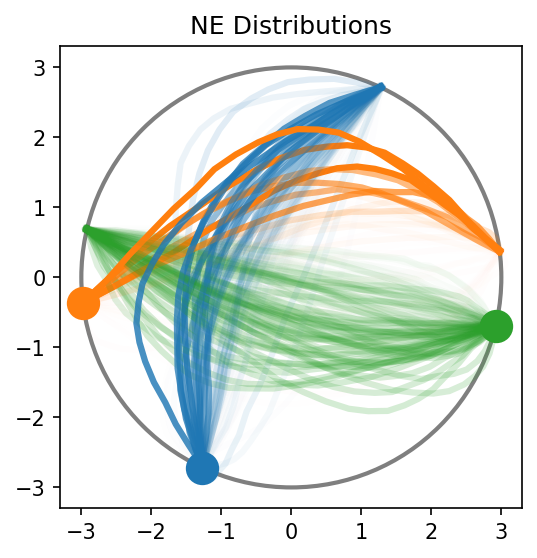

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=150)
ax.set_title('NE Distributions')
ax.set_xlim(-1.1*circle_radius, 1.1*circle_radius)
ax.set_ylim(-1.1*circle_radius, 1.1*circle_radius)
ax.set_aspect('equal')

circle = plt.Circle((0.0, 0.0), circle_radius, fill=False, color='k', linewidth=2, alpha=0.5)
ax.add_patch(circle)

traj_1_np = traj_1.cpu().numpy()
traj_2_np = traj_2.cpu().numpy()
traj_3_np = traj_3.cpu().numpy()
ax.plot(traj_1_np[0,0], traj_1_np[0,1], marker='o', markersize=15, color='C0')
ax.plot(traj_2_np[0,0], traj_2_np[0,1], marker='o', markersize=15, color='C1')
ax.plot(traj_3_np[0,0], traj_3_np[0,1], marker='o', markersize=15, color='C2')

traj_samples_1_np = traj_samples_1.cpu().numpy()
traj_samples_2_np = traj_samples_2.cpu().numpy()
traj_samples_3_np = traj_samples_3.cpu().numpy()
weights_1_np = weights_1.cpu().numpy()
weights_2_np = weights_2.cpu().numpy()
weights_3_np = weights_3.cpu().numpy()
for traj_1_i, traj_2_i, traj_3_i, w1, w2, w3 in zip(traj_samples_1_np, traj_samples_2_np, traj_samples_3_np, weights_1_np, weights_2_np, weights_3_np):
    ax.plot(traj_1_i[:,0], traj_1_i[:,1], linestyle='-', linewidth=3, color='C0', alpha=np.minimum(1.0, 0.05*w1))
    ax.plot(traj_2_i[:,0], traj_2_i[:,1], linestyle='-', linewidth=3, color='C1', alpha=np.minimum(1.0, 0.05*w2))
    ax.plot(traj_3_i[:,0], traj_3_i[:,1], linestyle='-', linewidth=3, color='C2', alpha=np.minimum(1.0, 0.05*w3))
    
plt.show()
plt.close()

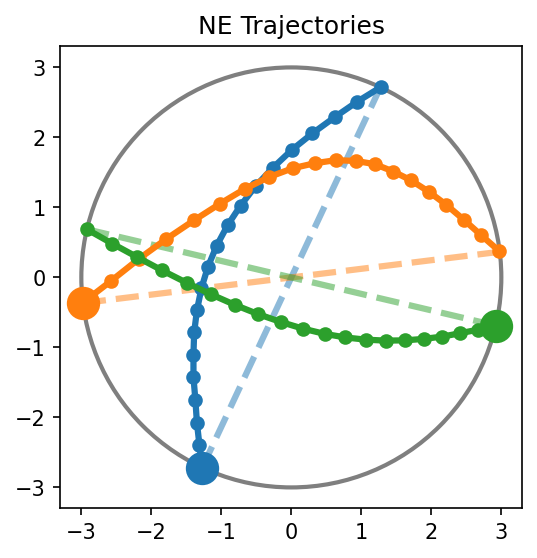

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=150)
ax.set_title('NE Trajectories')
ax.set_xlim(-1.1*circle_radius, 1.1*circle_radius)
ax.set_ylim(-1.1*circle_radius, 1.1*circle_radius)
ax.set_aspect('equal')

circle = plt.Circle((0.0, 0.0), circle_radius, fill=False, color='k', linewidth=2, alpha=0.5)
ax.add_patch(circle)

traj_1_np = traj_1.cpu().numpy()
traj_2_np = traj_2.cpu().numpy()
traj_3_np = traj_3.cpu().numpy()
opt_traj_1_np = opt_traj_1.cpu().numpy()
opt_traj_2_np = opt_traj_2.cpu().numpy()
opt_traj_3_np = opt_traj_3.cpu().numpy()

ax.plot(traj_1_np[0,0], traj_1_np[0,1], marker='o', markersize=15, color='C0')
ax.plot(traj_2_np[0,0], traj_2_np[0,1], marker='o', markersize=15, color='C1')
ax.plot(traj_3_np[0,0], traj_3_np[0,1], marker='o', markersize=15, color='C2')

ax.plot(traj_1_np[:,0], traj_1_np[:,1], linestyle='--', linewidth=3, color='C0', alpha=0.5)
ax.plot(traj_2_np[:,0], traj_2_np[:,1], linestyle='--', linewidth=3, color='C1', alpha=0.5)
ax.plot(traj_3_np[:,0], traj_3_np[:,1], linestyle='--', linewidth=3, color='C2', alpha=0.5)

ax.plot(opt_traj_1_np[:,0], opt_traj_1_np[:,1], linestyle='-', marker='o', linewidth=3, color='C0', alpha=1.0)
ax.plot(opt_traj_2_np[:,0], opt_traj_2_np[:,1], linestyle='-', marker='o', linewidth=3, color='C1', alpha=1.0)
ax.plot(opt_traj_3_np[:,0], opt_traj_3_np[:,1], linestyle='-', marker='o', linewidth=3, color='C2', alpha=1.0)

plt.show()
plt.close()